In [ ]:
import os
import json
import s3fs
from dotenv import load_dotenv
import random
import xarray as xr
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

In [3]:
load_dotenv()

True

In [ ]:
s3_options = {
    "key": os.getenv('MINIO_ACCESS_KEY'),
    "secret": os.getenv('MINIO_SECRET_KEY'),
    "client_kwargs": {'endpoint_url': os.getenv('MINIO_ENDPOINT_URL', 'http://localhost:9000')},
    "config_kwargs": {'s3': {'addressing_style': 'path'}} # Important for MinIO
}
s3 = s3fs.S3FileSystem(**s3_options)
bucket_name = os.getenv('MINIO_BUCKET_NAME', 'fusion-lake')
with open('cloud_masks_data.json', 'r') as f:
    data = json.load(f)

# Dynamic Dataloader

In [ ]:
def extract_patch(ds, patch_row, patch_col, patch_size=384):
    y_start = patch_row * patch_size
    x_start = patch_col * patch_size

    # Handle edge cases so we don't go out of bounds
    y_end = min(y_start + patch_size, ds.dims['y'])
    x_end = min(x_start + patch_size, ds.dims['x'])

    patch = ds.isel(
        y=slice(y_start, y_end),
        x=slice(x_start, x_end)
    )
    return patch

In [7]:
class CloudBalancedDatasetWithSynthesis(Dataset):
    def __init__(self, data_dict, s3_options, bucket_name, samples_per_bin=200, patch_size=384):
        """
        data_dict: dict of the form {'8': high_res_dict, '10': high_res_dict, ...}
        where each high_res_dict is a dict with keys as cloud bins like '0', '1', etc.
        """
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())  # Outer keys: '8', '10', '30', etc.
        self.samples_per_bin = samples_per_bin
        self.s3_options = s3_options
        self.bucket_name = bucket_name
        self.patch_size = patch_size

        self.cloud_bins = self._infer_common_bins()
        self.total_samples = len(self.keys) * len(self.cloud_bins) * self.samples_per_bin
        
        self.prepare_epoch()
        
    def _infer_common_bins(self):
        """Assume all high_res dicts share the same cloud bins."""
        any_key = next(iter(self.data_dict))
        return list(self.data_dict[any_key].keys())

    def prepare_epoch(self):
        self.sampled_data = []

        for group_key in self.keys:
            high_res = self.data_dict[group_key]
            clear_pool = [x for x in high_res['0'] if self.is_valid(x)]

            if not clear_pool:
                raise ValueError(f"No valid clear images in group {group_key}")

            for bin_key in self.cloud_bins:
                bin_images = [x for x in high_res[bin_key] if self.is_valid(x)]

                if len(bin_images) >= self.samples_per_bin:
                    selected = random.sample(bin_images, self.samples_per_bin)
                    self.sampled_data.extend([('real', x, group_key, bin_key) for x in selected])
                else:
                    self.sampled_data.extend([('real', x, group_key, bin_key) for x in bin_images])
                    deficit = self.samples_per_bin - len(bin_images)

                    for _ in range(deficit):
                        cloudy_image = random.choice(bin_images) if bin_images else random.choice(clear_pool)
                        clear_image = random.choice(clear_pool)
                        self.sampled_data.append(('synthetic', (clear_image, cloudy_image), group_key, bin_key))

        if not self.sampled_data:
            raise ValueError("No usable samples could be prepared.")

        random.shuffle(self.sampled_data)
        print(f"✅ Prepared {len(self.sampled_data)} samples from {len(self.keys)} groups × {len(self.cloud_bins)} bins × {self.samples_per_bin}.")

    def __len__(self):
        return len(self.sampled_data)

    def __getitem__(self, idx):
        tag, data, group_key, bin_key = self.sampled_data[idx]

        if tag == 'real':
            row, col, zarr_path, cloud_pct = data

            ds = xr.open_zarr(f"s3://{self.bucket_name}/{zarr_path}", 
                              storage_options=self.s3_options, 
                              consolidated=True, 
                              chunks={})

            patch_ds = extract_patch(ds, row, col, self.patch_size)
            band = list(patch_ds.keys())[0]
            patch = patch_ds[band].load().values

            patch = patch.astype(np.float32)
            patch = np.nan_to_num(patch)
            if patch.max() > patch.min():
                patch = (patch - patch.min()) / (patch.max() - patch.min())

            return patch, cloud_pct, group_key, bin_key

        else:  # synthetic
            clear_data, cloud_data = data
            synthetic_patch, cloud_pct = self.overlay_and_extract(clear_data, cloud_data)
            return synthetic_patch, cloud_pct, group_key, bin_key

    def overlay_and_extract(self, clear_image_data, cloud_image_data):
        clear_row, clear_col, clear_zarr_link, _ = clear_image_data
        cloud_row, cloud_col, cloud_zarr_link, _ = cloud_image_data

        clear_path = f"s3://{self.bucket_name}/{clear_zarr_link}"
        cloud_path = f"s3://{self.bucket_name}/{cloud_zarr_link}"
        mask_path = f"s3://{self.bucket_name}/{cloud_zarr_link.replace('raw', 'mask')}"

        clear_ds = xr.open_zarr(clear_path, storage_options=self.s3_options, consolidated=True, chunks={})
        cloud_ds = xr.open_zarr(cloud_path, storage_options=self.s3_options, consolidated=True, chunks={})
        mask_ds = xr.open_zarr(mask_path, storage_options=self.s3_options, consolidated=True, chunks={})

        clear_patch = extract_patch(clear_ds, clear_row, clear_col, self.patch_size)
        cloud_patch = extract_patch(cloud_ds, cloud_row, cloud_col, self.patch_size)
        mask_patch = extract_patch(mask_ds, cloud_row, cloud_col, self.patch_size)

        clear = clear_patch[list(clear_patch.keys())[0]].load().values.astype(np.float32)
        cloud = cloud_patch[list(cloud_patch.keys())[0]].load().values.astype(np.float32)
        mask = mask_patch[list(mask_patch.keys())[0]].load().values

        clear = np.nan_to_num(clear)
        cloud = np.nan_to_num(cloud)
        mask = (np.nan_to_num(mask) > 0).astype(bool)

        if clear.shape != cloud.shape:
            raise ValueError(f"Shape mismatch: {clear.shape} vs {cloud.shape}")

        # Normalize
        for img in [clear, cloud]:
            if img.max() > img.min():
                img -= img.min()
                img /= (img.max() + 1e-8)

        # Overlay cloud onto clear
        mask_3d = np.stack([mask] * clear.shape[-1], axis=-1)
        synthetic = np.where(mask_3d, cloud, clear).astype(np.float32)

        # Cloud cover %
        cloud_pct = round(100.0 * np.sum(mask) / mask.size, 2)

        return synthetic, cloud_pct
    def is_valid(self, sample):
        row, col, zarr_path, _ = sample
        ds = xr.open_zarr(
            store=f"s3://{self.bucket_name}/{zarr_path}",
            storage_options=self.s3_options,
            consolidated=True,
            chunks={}
        )
        patch = extract_patch(ds, row, col, patch_size=self.patch_size)
        band = list(patch.keys())[0]
        data = patch[band]
        return data.shape[0] == self.patch_size and data.shape[1] == self.patch_size


## 200 Samples per bin per resolution

In [ ]:
dataset = CloudBalancedDatasetWithSynthesis(
    data_dict=data,
    s3_options=s3_options,
    bucket_name=bucket_name,
    samples_per_bin=200,
    patch_size=384
)

✅ Prepared 12600 samples from 3 groups × 21 bins × 200.


In [15]:
num_bins = 21
real_counts = defaultdict(int)
synthetic_counts = defaultdict(int)

# New: to track counts per resolution
real_resolution_counts = defaultdict(lambda: defaultdict(int))       # e.g., real_resolution_counts['8'][bin_id]
synthetic_resolution_counts = defaultdict(lambda: defaultdict(int))  # e.g., synthetic_resolution_counts['8'][bin_id]


In [16]:
num_epochs = 1 
for epoch in range(num_epochs):
    # dataset.prepare_epoch()

    for i in tqdm(range(len(dataset))):
        image, cloud_pct, group_key, bin_key = dataset[i]

        # Clamp to bin 20 if cloud_pct == 100
        bin_id = min(int(cloud_pct // 5), 20)

        tag, _data, _group, _bin = dataset.sampled_data[i]
        
        if tag == "real":
            real_counts[bin_id] += 1
            real_resolution_counts[group_key][bin_id] += 1
        else:
            synthetic_counts[bin_id] += 1
            synthetic_resolution_counts[group_key][bin_id] += 1


100%|██████████| 12600/12600 [07:54<00:00, 26.53it/s]


In [17]:
real_counts = dict(sorted(real_counts.items()))
synthetic_counts = dict(sorted(synthetic_counts.items()))

In [18]:
real_resolution_counts = dict(sorted(real_resolution_counts.items()))
synthetic_resolution_counts = dict(sorted(synthetic_resolution_counts.items()))

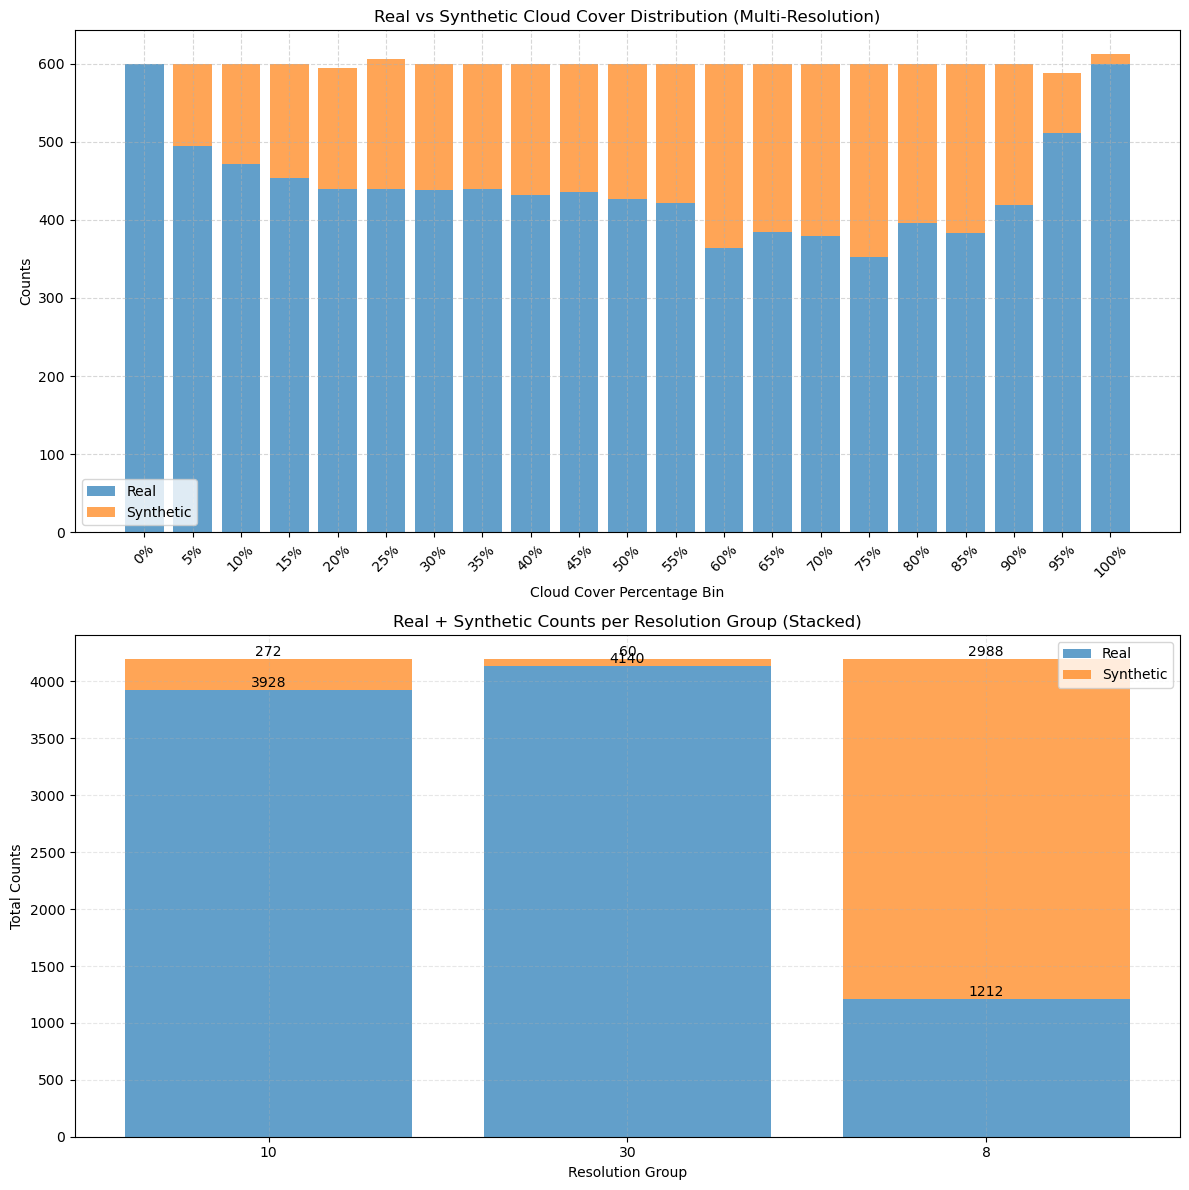

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for the first plot (cloud cover distribution)
real_counts_list = [real_counts.get(str(bin_id), 0) for bin_id in range(21)]
synthetic_counts_list = [synthetic_counts.get(str(bin_id), 0) for bin_id in range(21)]
bins = [f"{i*5}%" for i in range(21)]  # 0% to 100% in steps of 5%
x = np.arange(21)  # Bin IDs (0 to 20)

# Prepare data for the second plot (resolution group totals)
groups = np.sort(list(real_resolution_counts.keys()))
real_totals = [sum(real_resolution_counts[group].values()) for group in groups]
synthetic_totals = [sum(synthetic_resolution_counts[group].values()) for group in groups]

# Create a figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- First Subplot: Cloud Cover Distribution ---
ax1.bar(x, real_counts_list, label='Real', alpha=0.7)
ax1.bar(x, synthetic_counts_list, bottom=real_counts_list, label='Synthetic', alpha=0.7)
ax1.set_xlabel('Cloud Cover Percentage Bin')
ax1.set_ylabel('Counts')
ax1.set_title('Real vs Synthetic Cloud Cover Distribution (Multi-Resolution)')
ax1.set_xticks(x)
ax1.set_xticklabels(bins, rotation=45)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Second Subplot: Resolution Group Totals ---
ax2.bar(groups, real_totals, label='Real', alpha=0.7)
ax2.bar(groups, synthetic_totals, bottom=real_totals, label='Synthetic', alpha=0.7)

# Add value labels
for i, group in enumerate(groups):
    ax2.text(i, real_totals[i], f'{real_totals[i]}', ha='center', va='bottom')
    ax2.text(i, real_totals[i] + synthetic_totals[i], f'{synthetic_totals[i]}', ha='center', va='bottom')

ax2.set_xlabel('Resolution Group')
ax2.set_ylabel('Total Counts')
ax2.set_title('Real + Synthetic Counts per Resolution Group (Stacked)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

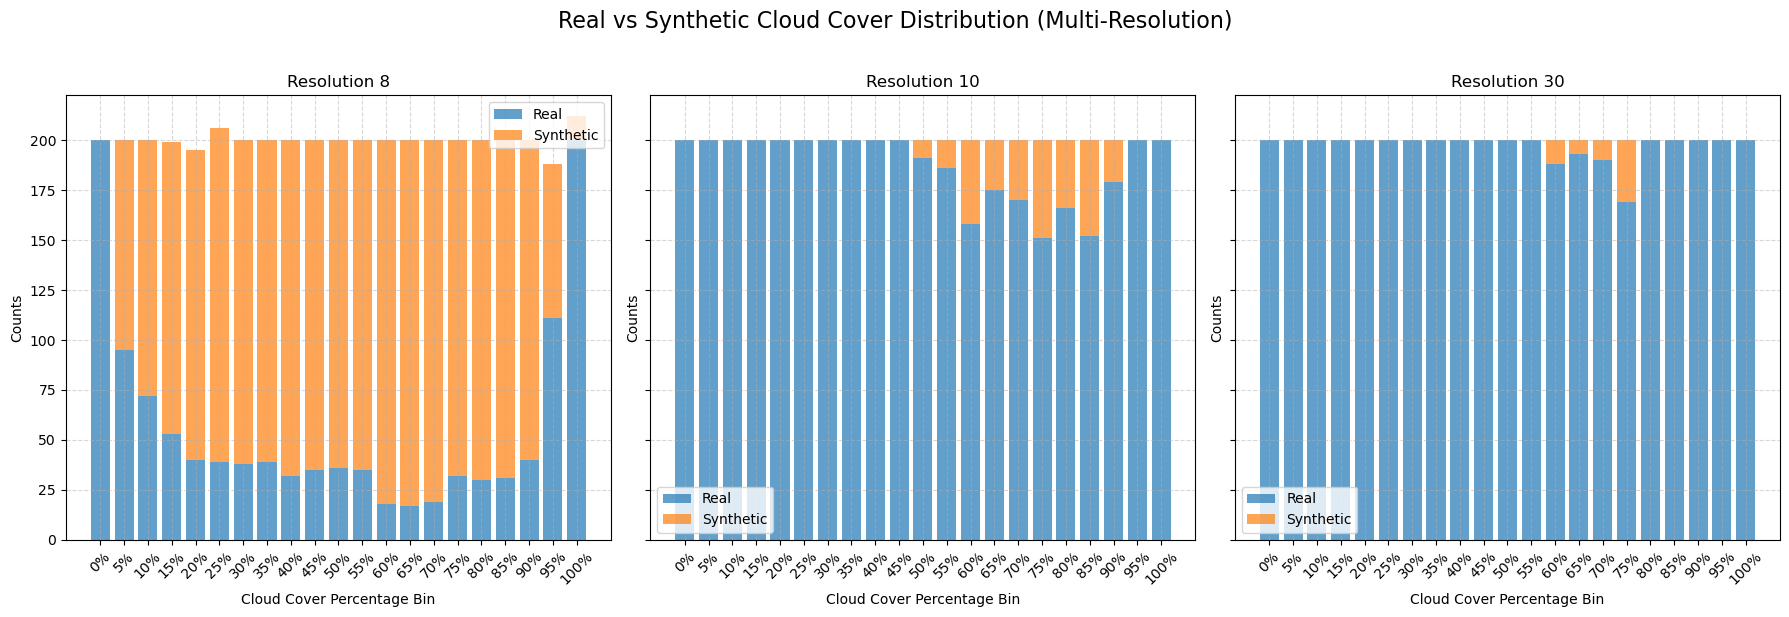

In [69]:
resolutions = ['8', '10', '30']
data = {
    'real': {
        '8': [real_resolution_counts['8'].get(str(bin_id), 0) for bin_id in range(21)],
        '10': [real_resolution_counts['10'].get(str(bin_id), 0) for bin_id in range(21)],
        '30': [real_resolution_counts['30'].get(str(bin_id), 0) for bin_id in range(21)]
    },
    'synthetic': {
        '8': [synthetic_resolution_counts['8'].get(str(bin_id), 0) for bin_id in range(21)],
        '10': [synthetic_resolution_counts['10'].get(str(bin_id), 0) for bin_id in range(21)],
        '30': [synthetic_resolution_counts['30'].get(str(bin_id), 0) for bin_id in range(21)]
    }
}

# Bin labels (0%, 5%, ..., 100%)
bins = [f"{i*5}%" for i in range(21)]  # 0% to 100% in steps of 5%
x = np.arange(21)  # Bin IDs (0 to 20)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each resolution in a separate subplot
for ax, res in zip(axes, resolutions):
    ax.bar(x, data['real'][res], label='Real', alpha=0.7)
    ax.bar(x, data['synthetic'][res], bottom=data['real'][res], label='Synthetic', alpha=0.7)
    
    ax.set_xlabel('Cloud Cover Percentage Bin')
    ax.set_ylabel('Counts')
    ax.set_title(f'Resolution {res}')
    ax.set_xticks(x)
    ax.set_xticklabels(bins, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

# Add a common title
fig.suptitle('Real vs Synthetic Cloud Cover Distribution (Multi-Resolution)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## 300 Samples per bin per resolution

In [28]:
dataset = CloudBalancedDatasetWithSynthesis(
    data_dict=data,
    s3_options=s3_options,
    bucket_name=bucket_name,
    samples_per_bin=300,
    patch_size=384
)

# loader = DataLoader(dataset, batch_size=16, shuffle=False)

✅ Prepared 18900 samples from 3 groups × 21 bins × 300.


In [31]:
num_bins = 21
real_counts_medium = defaultdict(int)
synthetic_counts_medium = defaultdict(int)

# New: to track counts per resolution
real_resolution_counts_medium = defaultdict(lambda: defaultdict(int))       # e.g., real_resolution_counts['8'][bin_id]
synthetic_resolution_counts_medium = defaultdict(lambda: defaultdict(int))  # e.g., synthetic_resolution_counts['8'][bin_id]


In [32]:
num_epochs = 1 
for epoch in range(num_epochs):
    # dataset.prepare_epoch()

    for i in tqdm(range(len(dataset))):
        image, cloud_pct, group_key, bin_key = dataset[i]

        # Clamp to bin 20 if cloud_pct == 100
        bin_id = min(int(cloud_pct // 5), 20)

        tag, _data, _group, _bin = dataset.sampled_data[i]
        
        if tag == "real":
            real_counts_medium[bin_id] += 1
            real_resolution_counts_medium[group_key][bin_id] += 1
        else:
            synthetic_counts_medium[bin_id] += 1
            synthetic_resolution_counts_medium[group_key][bin_id] += 1


100%|██████████| 18900/18900 [13:22<00:00, 23.56it/s]


In [33]:
real_counts_medium = dict(sorted(real_counts_medium.items()))
synthetic_counts_medium = dict(sorted(synthetic_counts_medium.items()))

In [34]:
real_resolution_counts_medium = dict(sorted(real_resolution_counts_medium.items()))
synthetic_resolution_counts_medium = dict(sorted(synthetic_resolution_counts_medium.items()))

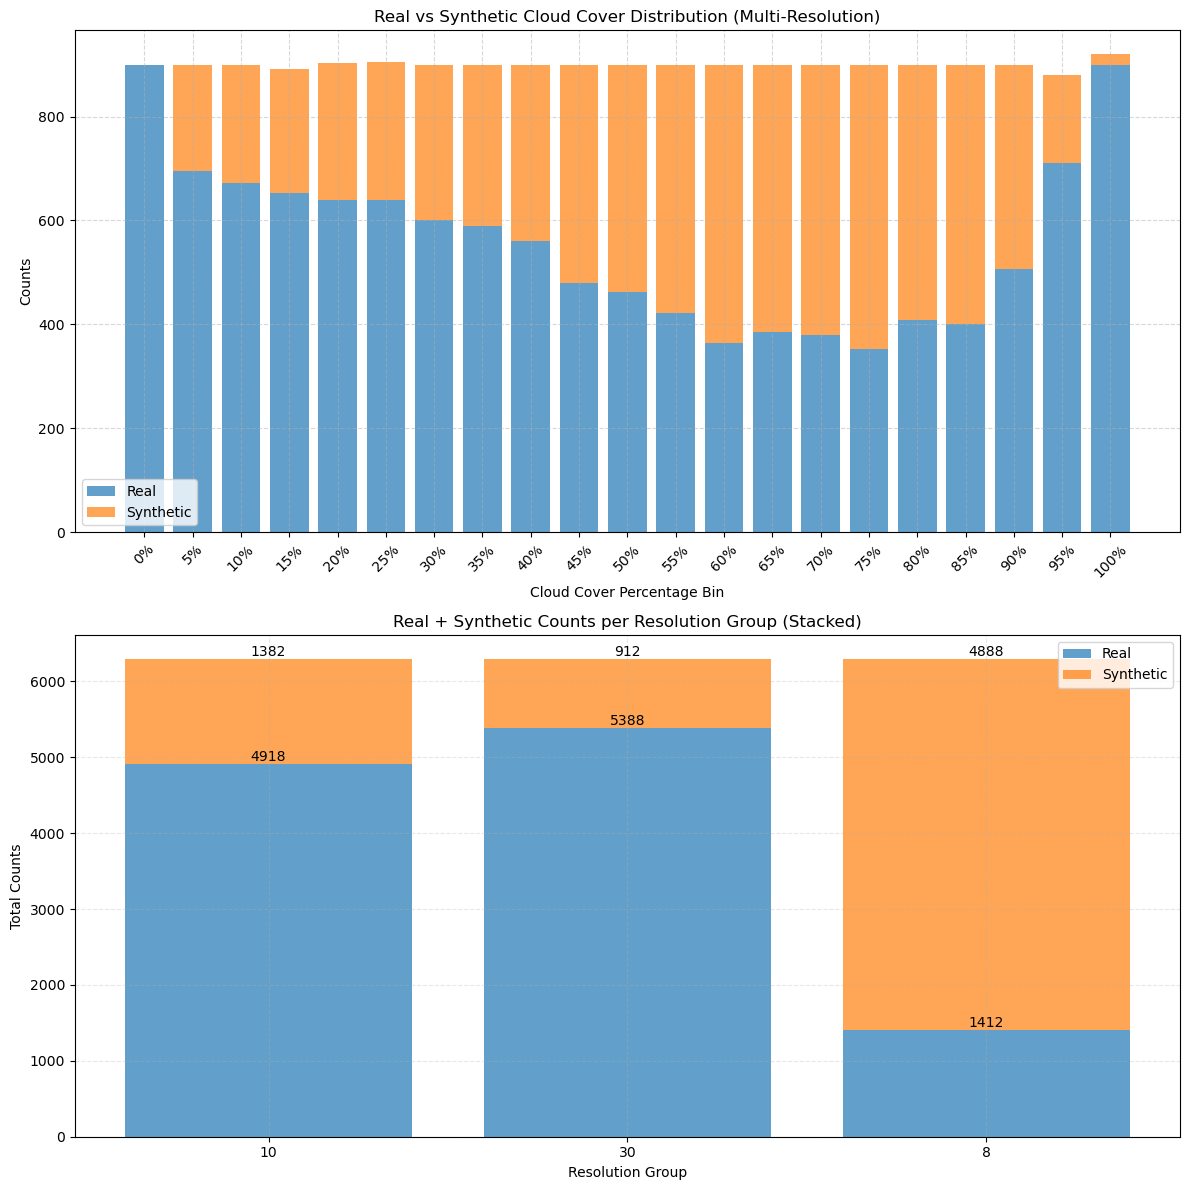

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for the first plot (cloud cover distribution)
real_counts_medium_list = [real_counts_medium.get(bin_id, 0) for bin_id in range(21)]
synthetic_counts_medium_list = [synthetic_counts_medium.get(bin_id, 0) for bin_id in range(21)]
bins = [f"{i*5}%" for i in range(21)]  # 0% to 100% in steps of 5%
x = np.arange(21)  # Bin IDs (0 to 20)

# Prepare data for the second plot (resolution group totals)
groups = np.sort(list(real_resolution_counts_medium.keys()))
real_totals = [sum(real_resolution_counts_medium[group].values()) for group in groups]
synthetic_totals = [sum(synthetic_resolution_counts_medium[group].values()) for group in groups]

# Create a figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- First Subplot: Cloud Cover Distribution ---
ax1.bar(x, real_counts_medium_list, label='Real', alpha=0.7)
ax1.bar(x, synthetic_counts_medium_list, bottom=real_counts_medium_list, label='Synthetic', alpha=0.7)
ax1.set_xlabel('Cloud Cover Percentage Bin')
ax1.set_ylabel('Counts')
ax1.set_title('Real vs Synthetic Cloud Cover Distribution (Multi-Resolution)')
ax1.set_xticks(x)
ax1.set_xticklabels(bins, rotation=45)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Second Subplot: Resolution Group Totals ---
ax2.bar(groups, real_totals, label='Real', alpha=0.7)
ax2.bar(groups, synthetic_totals, bottom=real_totals, label='Synthetic', alpha=0.7)

# Add value labels
for i, group in enumerate(groups):
    ax2.text(i, real_totals[i], f'{real_totals[i]}', ha='center', va='bottom')
    ax2.text(i, real_totals[i] + synthetic_totals[i], f'{synthetic_totals[i]}', ha='center', va='bottom')

ax2.set_xlabel('Resolution Group')
ax2.set_ylabel('Total Counts')
ax2.set_title('Real + Synthetic Counts per Resolution Group (Stacked)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

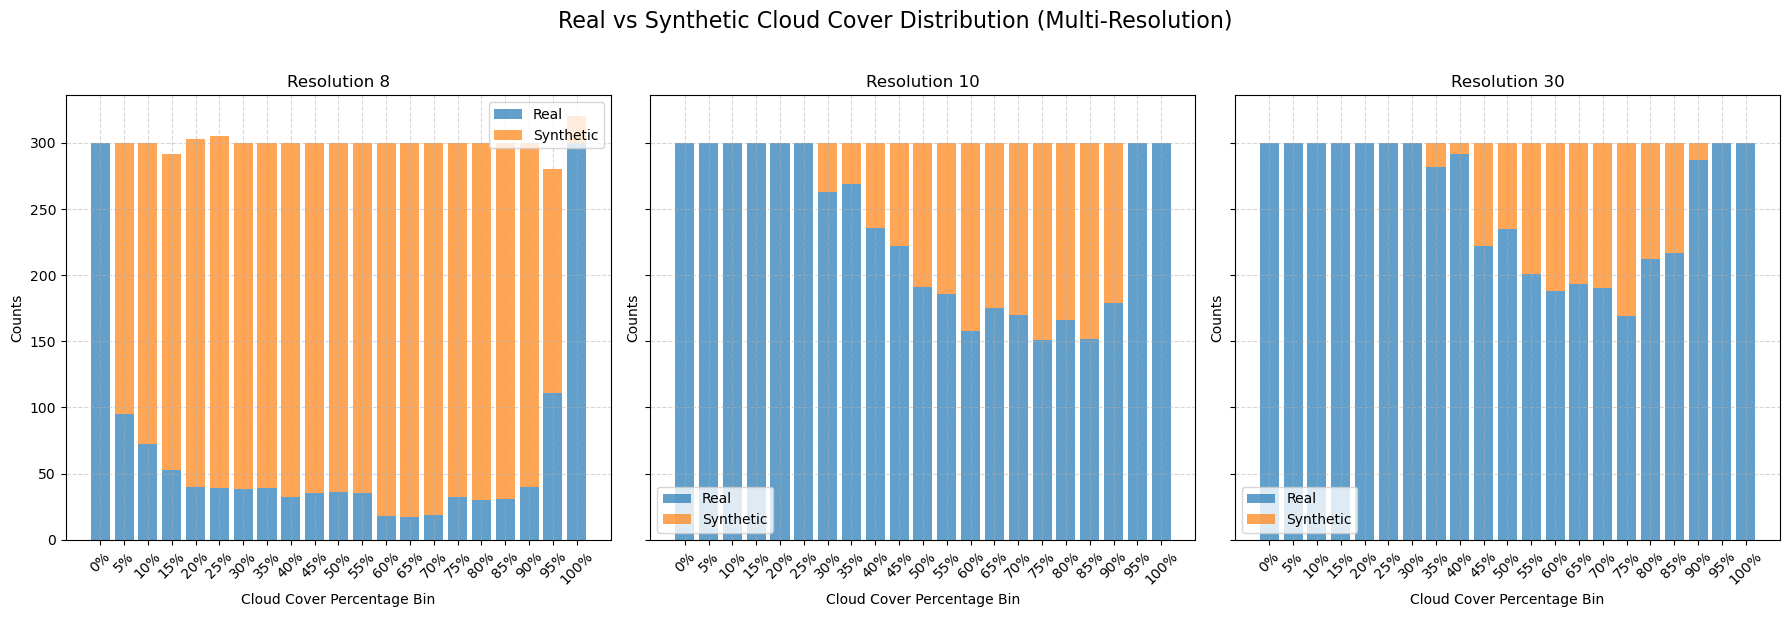

In [51]:
resolutions = ['8', '10', '30']
data = {
    'real': {
        '8': [real_resolution_counts_medium['8'].get(bin_id, 0) for bin_id in range(21)],
        '10': [real_resolution_counts_medium['10'].get(bin_id, 0) for bin_id in range(21)],
        '30': [real_resolution_counts_medium['30'].get(bin_id, 0) for bin_id in range(21)]
    },
    'synthetic': {
        '8': [synthetic_resolution_counts_medium['8'].get(bin_id, 0) for bin_id in range(21)],
        '10': [synthetic_resolution_counts_medium['10'].get(bin_id, 0) for bin_id in range(21)],
        '30': [synthetic_resolution_counts_medium['30'].get(bin_id, 0) for bin_id in range(21)]
    }
}

# Bin labels (0%, 5%, ..., 100%)
bins = [f"{i*5}%" for i in range(21)]  # 0% to 100% in steps of 5%
x = np.arange(21)  # Bin IDs (0 to 20)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each resolution in a separate subplot
for ax, res in zip(axes, resolutions):
    ax.bar(x, data['real'][res], label='Real', alpha=0.7)
    ax.bar(x, data['synthetic'][res], bottom=data['real'][res], label='Synthetic', alpha=0.7)
    
    ax.set_xlabel('Cloud Cover Percentage Bin')
    ax.set_ylabel('Counts')
    ax.set_title(f'Resolution {res}')
    ax.set_xticks(x)
    ax.set_xticklabels(bins, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

# Add a common title
fig.suptitle('Real vs Synthetic Cloud Cover Distribution (Multi-Resolution)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## 500 Samples per bin per resolution

In [40]:
dataset_large = CloudBalancedDatasetWithSynthesis(
    data_dict=data,
    s3_options=s3_options,
    bucket_name=bucket_name,
    samples_per_bin=500,
    patch_size=384
)

# loader = DataLoader(dataset, batch_size=16, shuffle=False)

✅ Prepared 31500 samples from 3 groups × 21 bins × 500.


In [41]:
num_bins = 21
real_counts_large = defaultdict(int)
synthetic_counts_large = defaultdict(int)

# New: to track counts per resolution
real_resolution_counts_large = defaultdict(lambda: defaultdict(int))       # e.g., real_resolution_counts['8'][bin_id]
synthetic_resolution_counts_large = defaultdict(lambda: defaultdict(int))  # e.g., synthetic_resolution_counts['8'][bin_id]


In [42]:
num_epochs = 1 
for epoch in range(num_epochs):
    # dataset.prepare_epoch()

    for i in tqdm(range(len(dataset_large))):
        image, cloud_pct, group_key, bin_key = dataset_large[i]

        # Clamp to bin 20 if cloud_pct == 100
        bin_id = min(int(cloud_pct // 5), 20)

        tag, _data, _group, _bin = dataset_large.sampled_data[i]
        
        if tag == "real":
            real_counts_large[bin_id] += 1
            real_resolution_counts_large[group_key][bin_id] += 1
        else:
            synthetic_counts_large[bin_id] += 1
            synthetic_resolution_counts_large[group_key][bin_id] += 1


100%|██████████| 31500/31500 [24:48<00:00, 21.16it/s]


In [43]:
real_counts_large = dict(sorted(real_counts_large.items()))
synthetic_counts_large = dict(sorted(synthetic_counts_large.items()))

In [44]:
real_resolution_counts_large = dict(sorted(real_resolution_counts_large.items()))
synthetic_resolution_counts_large = dict(sorted(synthetic_resolution_counts_large.items()))

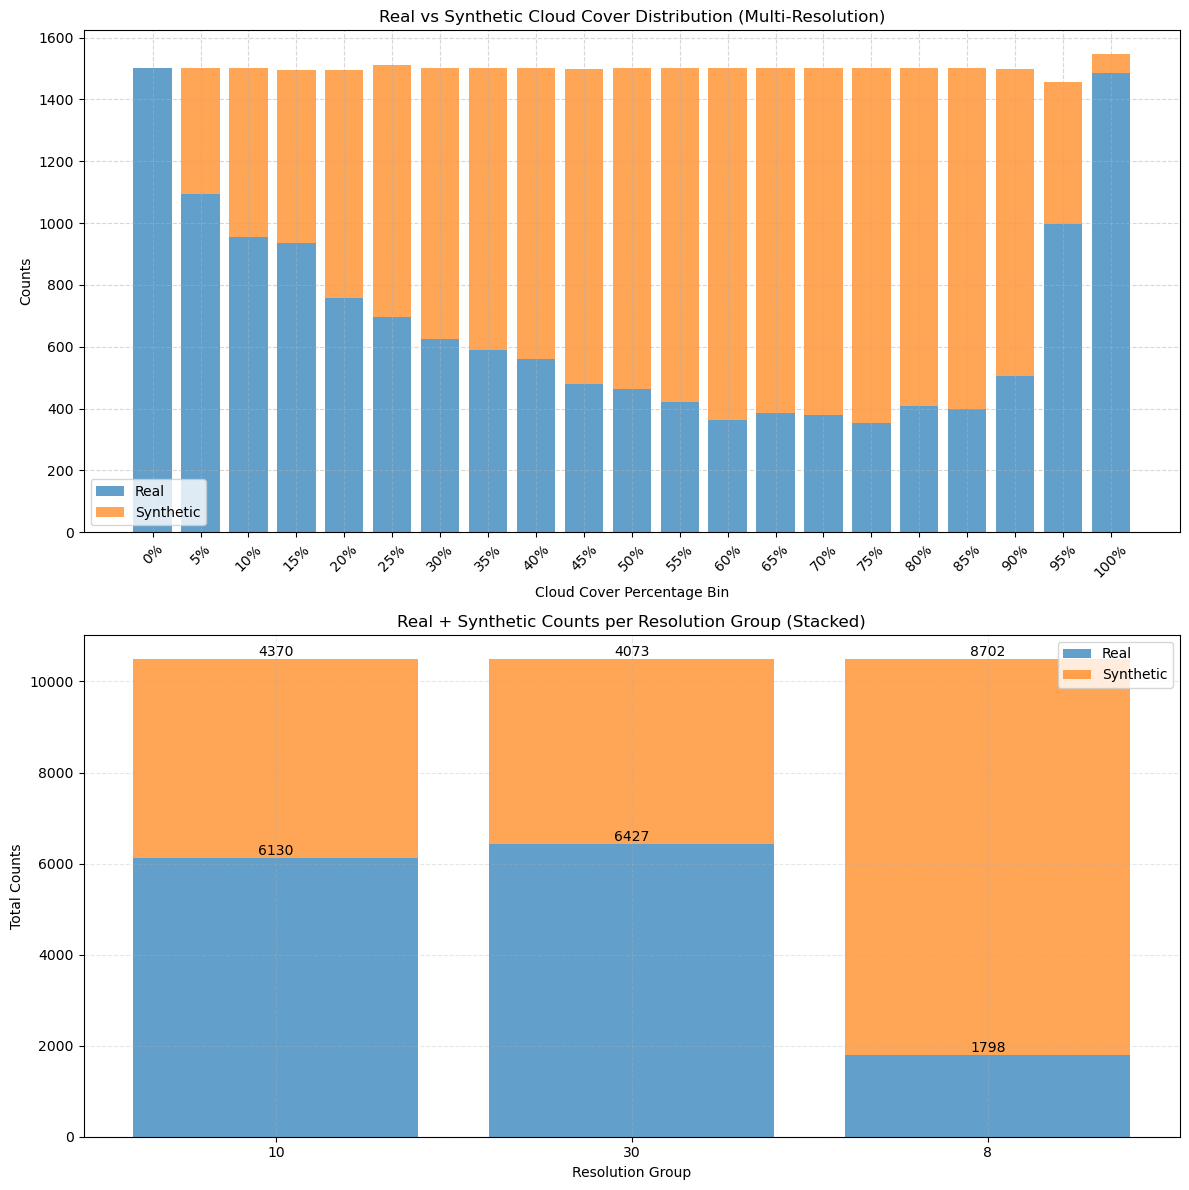

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for the first plot (cloud cover distribution)
real_counts_large_list = [real_counts_large.get(bin_id, 0) for bin_id in range(21)]
synthetic_counts_large_list = [synthetic_counts_large.get(bin_id, 0) for bin_id in range(21)]
bins = [f"{i*5}%" for i in range(21)]  # 0% to 100% in steps of 5%
x = np.arange(21)  # Bin IDs (0 to 20)

# Prepare data for the second plot (resolution group totals)
groups = np.sort(list(real_resolution_counts_large.keys()))
real_totals = [sum(real_resolution_counts_large[group].values()) for group in groups]
synthetic_totals = [sum(synthetic_resolution_counts_large[group].values()) for group in groups]

# Create a figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- First Subplot: Cloud Cover Distribution ---
ax1.bar(x, real_counts_large_list, label='Real', alpha=0.7)
ax1.bar(x, synthetic_counts_large_list, bottom=real_counts_large_list, label='Synthetic', alpha=0.7)
ax1.set_xlabel('Cloud Cover Percentage Bin')
ax1.set_ylabel('Counts')
ax1.set_title('Real vs Synthetic Cloud Cover Distribution (Multi-Resolution)')
ax1.set_xticks(x)
ax1.set_xticklabels(bins, rotation=45)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Second Subplot: Resolution Group Totals ---
ax2.bar(groups, real_totals, label='Real', alpha=0.7)
ax2.bar(groups, synthetic_totals, bottom=real_totals, label='Synthetic', alpha=0.7)

# Add value labels
for i, group in enumerate(groups):
    ax2.text(i, real_totals[i], f'{real_totals[i]}', ha='center', va='bottom')
    ax2.text(i, real_totals[i] + synthetic_totals[i], f'{synthetic_totals[i]}', ha='center', va='bottom')

ax2.set_xlabel('Resolution Group')
ax2.set_ylabel('Total Counts')
ax2.set_title('Real + Synthetic Counts per Resolution Group (Stacked)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

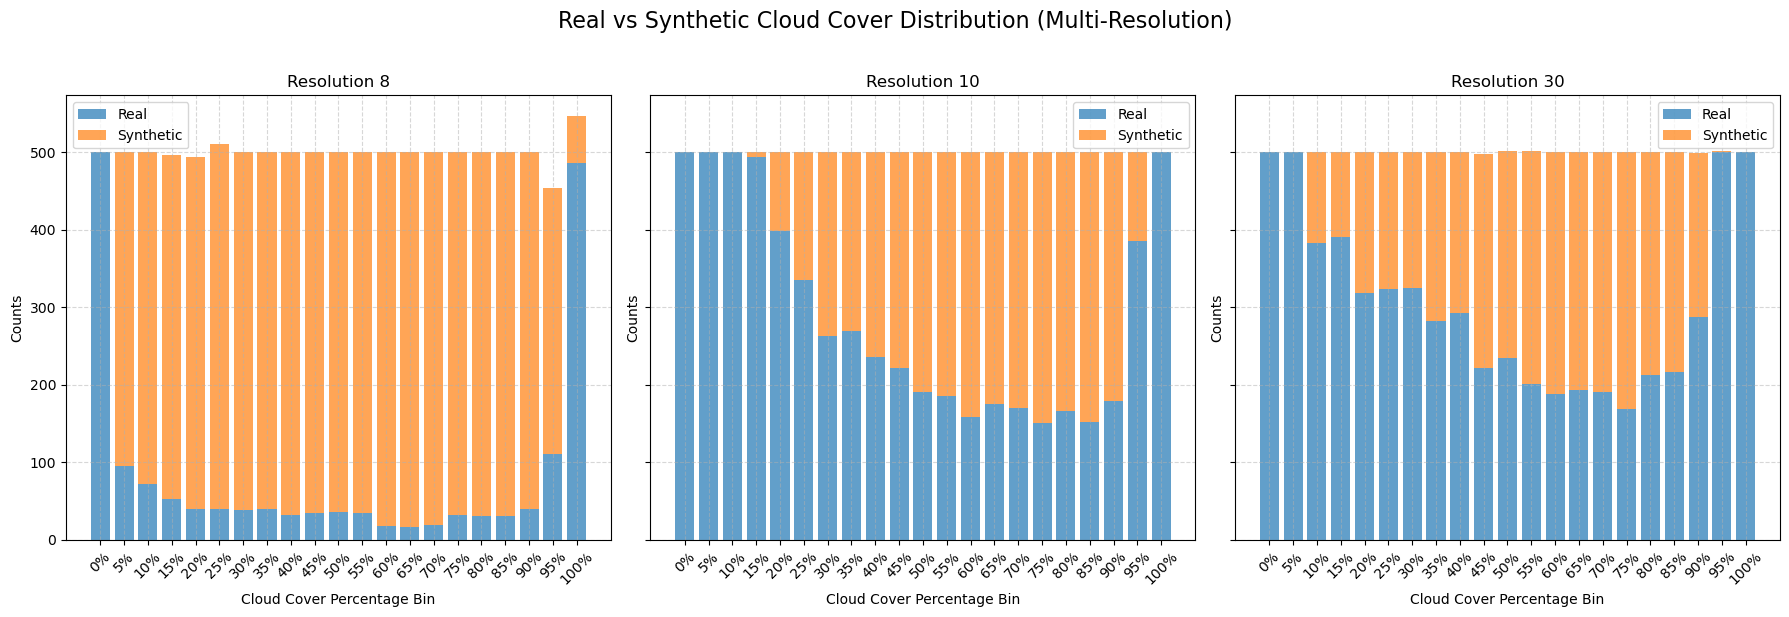

In [50]:
resolutions = ['8', '10', '30']
data = {
    'real': {
        '8': [real_resolution_counts_large['8'].get(bin_id, 0) for bin_id in range(21)],
        '10': [real_resolution_counts_large['10'].get(bin_id, 0) for bin_id in range(21)],
        '30': [real_resolution_counts_large['30'].get(bin_id, 0) for bin_id in range(21)]
    },
    'synthetic': {
        '8': [synthetic_resolution_counts_large['8'].get(bin_id, 0) for bin_id in range(21)],
        '10': [synthetic_resolution_counts_large['10'].get(bin_id, 0) for bin_id in range(21)],
        '30': [synthetic_resolution_counts_large['30'].get(bin_id, 0) for bin_id in range(21)]
    }
}

# Bin labels (0%, 5%, ..., 100%)
bins = [f"{i*5}%" for i in range(21)]  # 0% to 100% in steps of 5%
x = np.arange(21)  # Bin IDs (0 to 20)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each resolution in a separate subplot
for ax, res in zip(axes, resolutions):
    ax.bar(x, data['real'][res], label='Real', alpha=0.7)
    ax.bar(x, data['synthetic'][res], bottom=data['real'][res], label='Synthetic', alpha=0.7)
    
    ax.set_xlabel('Cloud Cover Percentage Bin')
    ax.set_ylabel('Counts')
    ax.set_title(f'Resolution {res}')
    ax.set_xticks(x)
    ax.set_xticklabels(bins, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

# Add a common title
fig.suptitle('Real vs Synthetic Cloud Cover Distribution (Multi-Resolution)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## Balancing Train,Val and Test loaders

In [8]:
dataset = CloudBalancedDatasetWithSynthesis(
    data_dict=data,
    s3_options=s3_options,
    bucket_name=bucket_name,
    samples_per_bin=200,
    patch_size=384
)

✅ Prepared 12600 samples from 3 groups × 21 bins × 200.


In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [11]:
# Step 1: Organize indices by (group_key, bin_key)
bins = defaultdict(list)
for idx, (_, _, group_key, bin_key) in enumerate(dataset.sampled_data):
    bins[(group_key, bin_key)].append(idx)

# Step 2: Split each bin separately
train_idx, val_idx, test_idx = [], [], []

for bin_key, indices in bins.items():
    train_i, rest = train_test_split(indices, train_size=train_ratio, random_state=42)
    val_i, test_i = train_test_split(rest, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)
    
    train_idx.extend(train_i)
    val_idx.extend(val_i)
    test_idx.extend(test_i)

# Step 3: Use Subset instead of random_split
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

In [19]:
def get_real_synthetic_distribution(dataset):
    # Structure: data[real_or_synth][group][bin] = count
    data = {"real": defaultdict(lambda: defaultdict(int)),
            "synthetic": defaultdict(lambda: defaultdict(int))}
    
    for tag, _, group_key, bin_key in dataset.sampled_data:
        tag = 'real' if tag == 'real' else 'synthetic'
        data[tag][str(group_key)][str(bin_key)] += 1
    
    return data

def get_real_synthetic_distribution_from_subset(subset, full_dataset):
    sampled_data = [full_dataset.sampled_data[i] for i in subset.indices]
    data = {"real": defaultdict(lambda: defaultdict(int)),
            "synthetic": defaultdict(lambda: defaultdict(int))}
    
    for tag, _, group_key, bin_key in sampled_data:
        tag = 'real' if tag == 'real' else 'synthetic'
        data[tag][str(group_key)][str(bin_key)] += 1

    return data

def plot_stacked_distribution(data, title="Dataset Distribution"):
    resolutions = sorted(set(data['real'].keys()) | set(data['synthetic'].keys()))
    bins = sorted(
        {int(b) for res in resolutions for b in (
            list(data['real'][res].keys()) + list(data['synthetic'][res].keys())
        )}
    )
    bins = list(map(str, bins)) 

    x = np.arange(len(bins))
    width = 0.35

    fig, axes = plt.subplots(1, len(resolutions), figsize=(6 * len(resolutions), 6), sharey=True)

    if len(resolutions) == 1:
        axes = [axes]  # Handle single subplot edge case

    for ax, res in zip(axes, resolutions):
        real_counts = [data['real'][res].get(bin_key, 0) for bin_key in bins]
        synth_counts = [data['synthetic'][res].get(bin_key, 0) for bin_key in bins]
        
        ax.bar(x, real_counts, width=width, label='Real', alpha=0.7, color='tab:blue')
        ax.bar(x, synth_counts, width=width, bottom=real_counts, label='Synthetic', alpha=0.7, color='tab:orange')
        
        ax.set_xlabel('Cloud Cover Bin')
        ax.set_title(f'Resolution {res}')
        ax.set_xticks(x)
        ax.set_xticklabels(bins, rotation=45)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()
    
    axes[0].set_ylabel('Counts')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

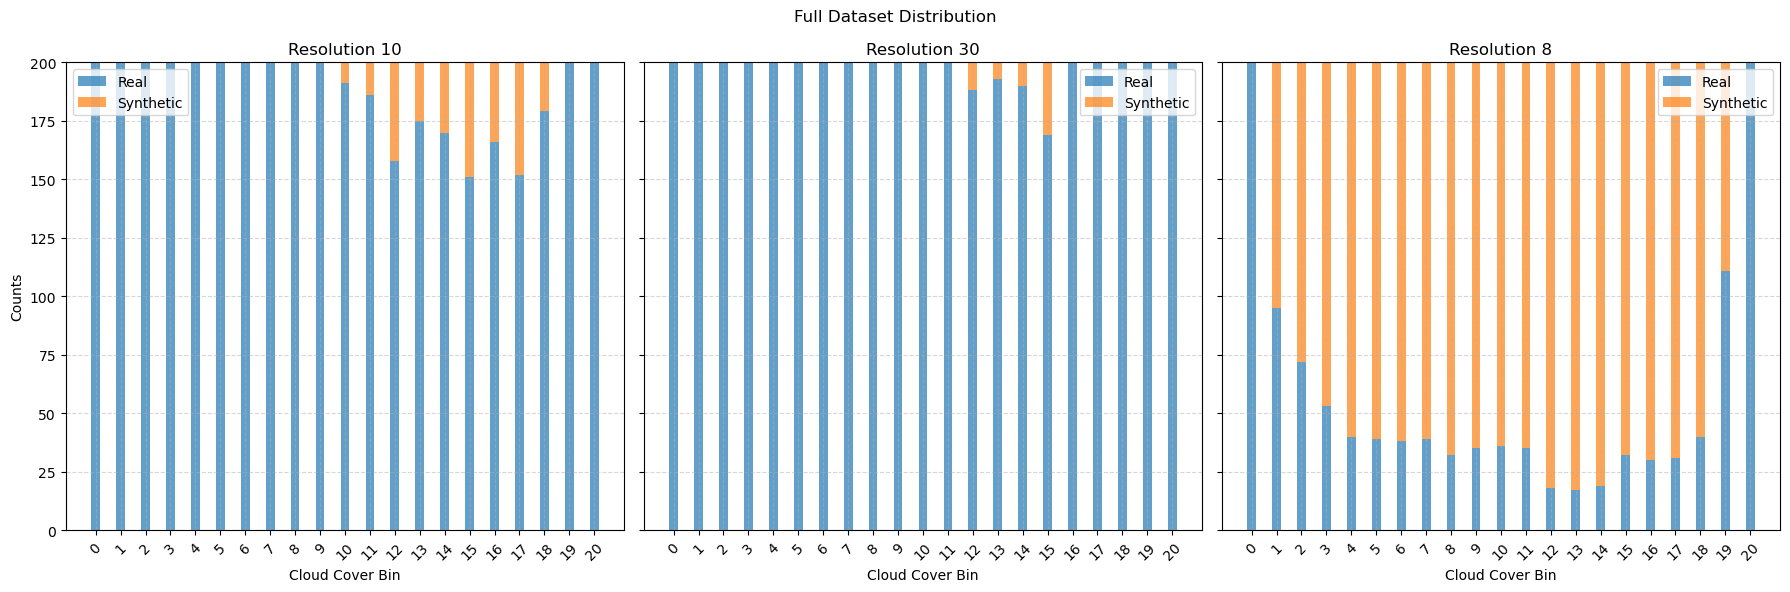

In [20]:
dist = get_real_synthetic_distribution(dataset)
plot_stacked_distribution(dist, title="Full Dataset Distribution")

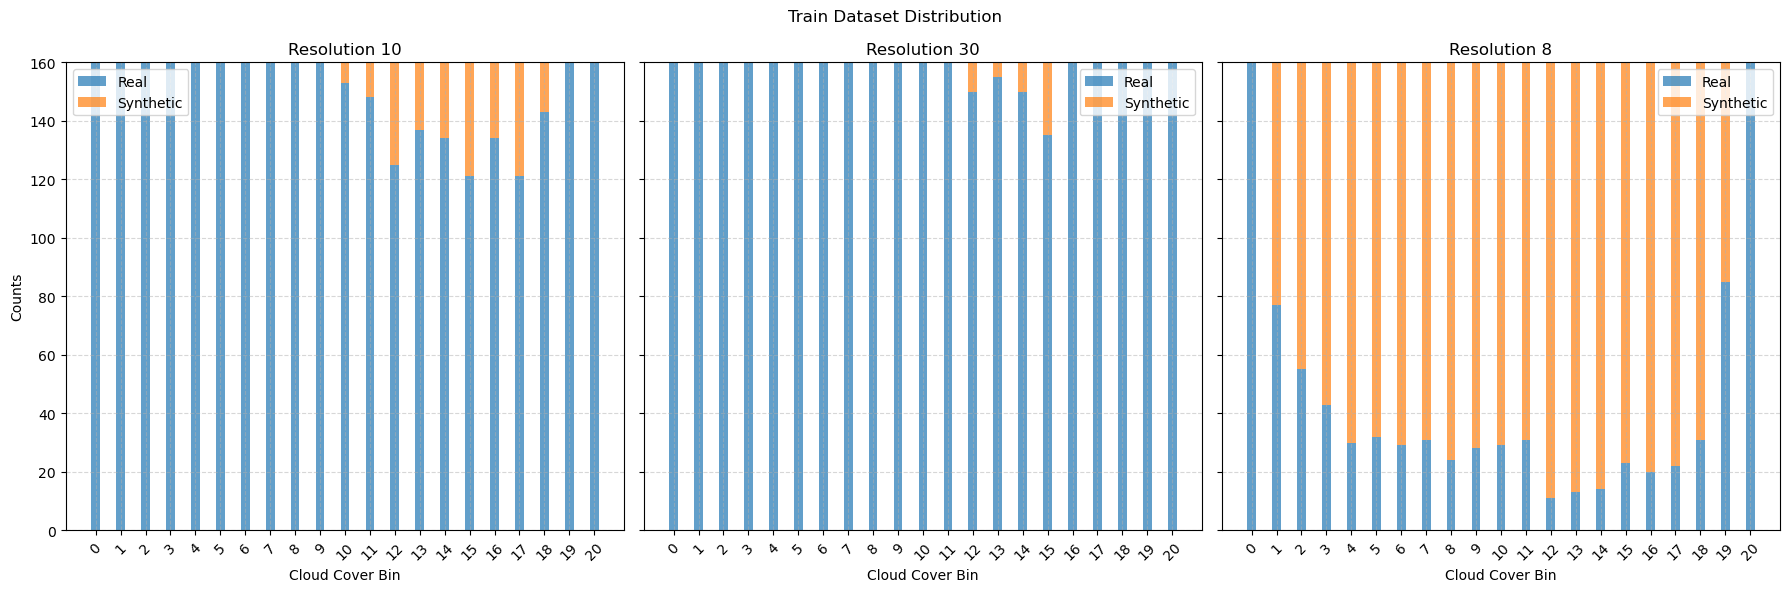

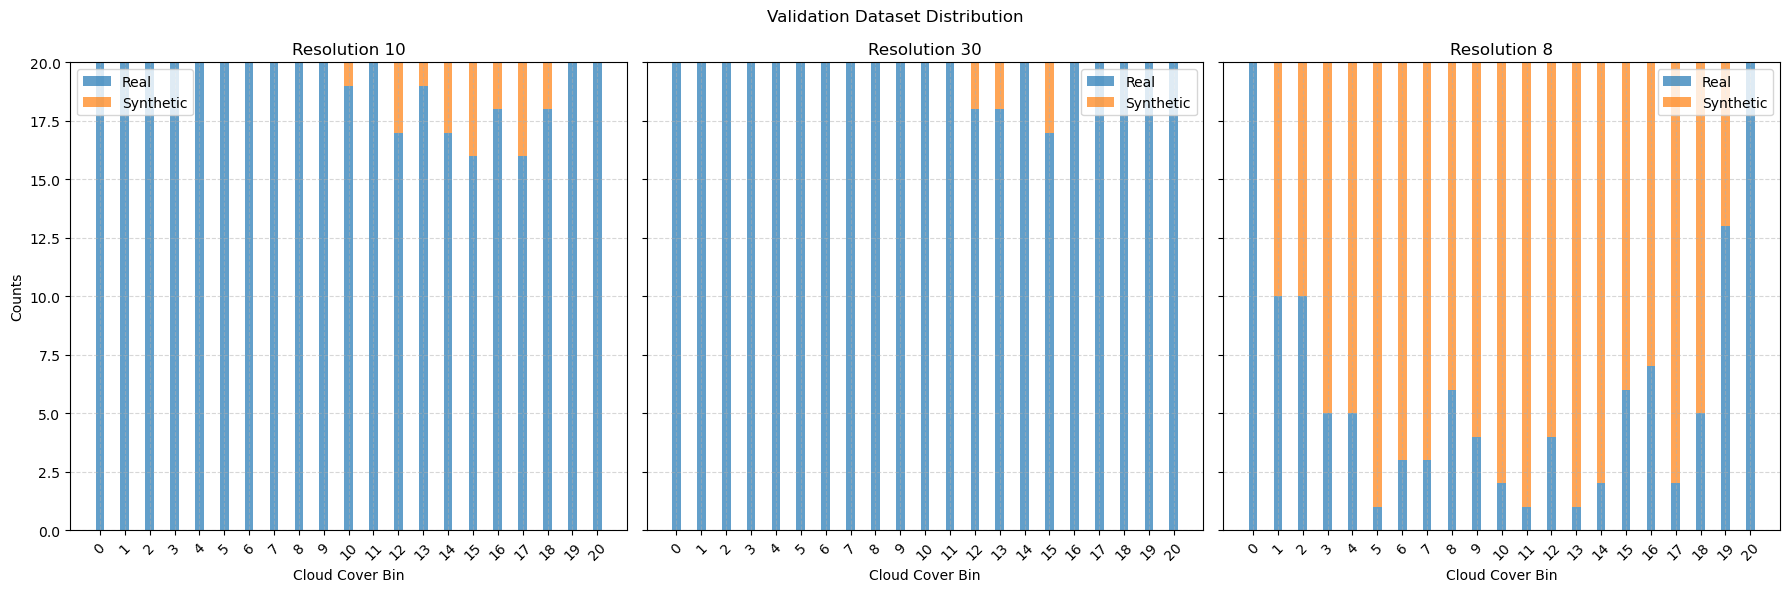

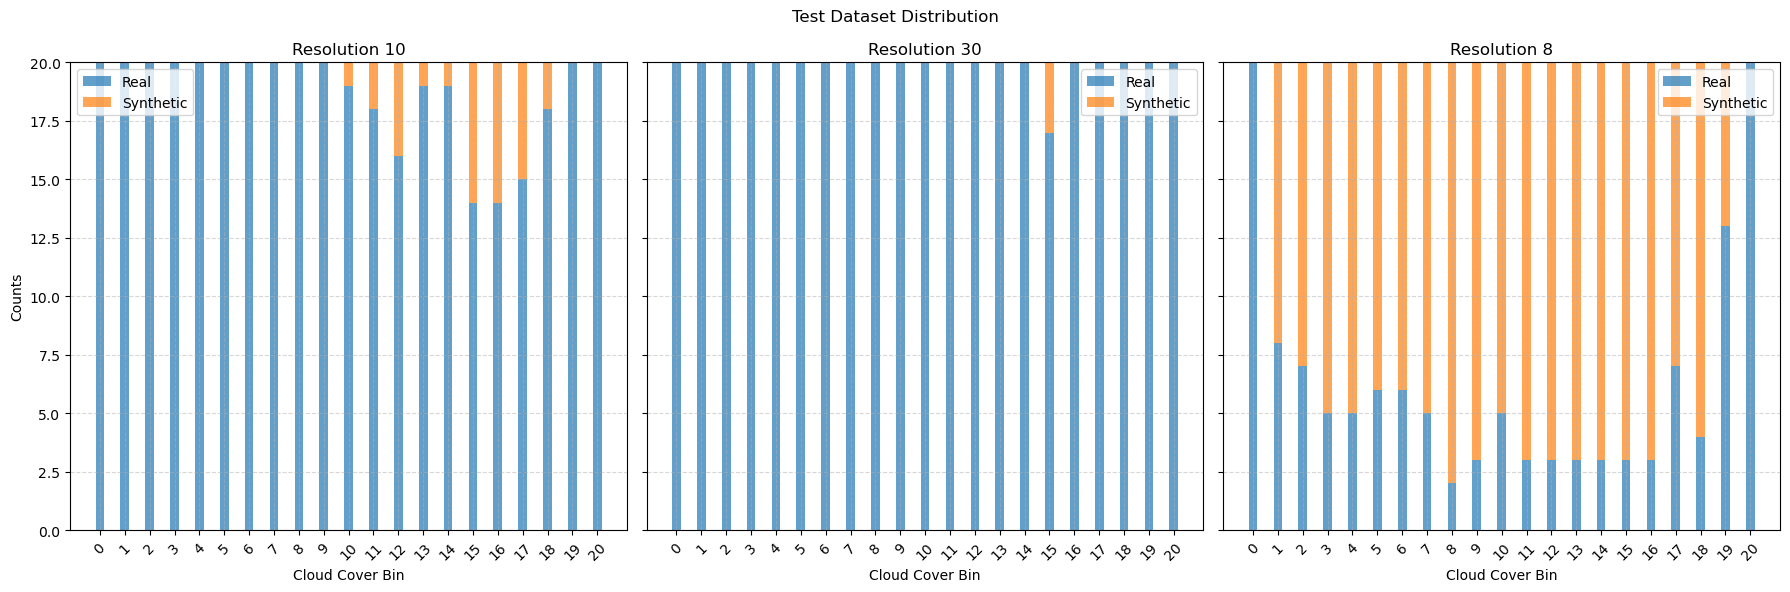

In [21]:
dist_train = get_real_synthetic_distribution_from_subset(train_dataset, dataset)
plot_stacked_distribution(dist_train, "Train Dataset Distribution")

dist_val = get_real_synthetic_distribution_from_subset(val_dataset, dataset)
plot_stacked_distribution(dist_val, "Validation Dataset Distribution")

dist_test = get_real_synthetic_distribution_from_subset(test_dataset, dataset)
plot_stacked_distribution(dist_test, "Test Dataset Distribution")